In [1]:
import torch
import numpy as np
import sys

import matplotlib.pyplot as plt

sys.path.insert(0,'../pulp-frontnet/PyTorch')
sys.path.insert(0,'../adversarial_frontnet/')
from Frontnet.Frontnet import FrontnetModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
from util import load_dataset, load_model
model_path = '../pulp-frontnet/PyTorch/Models/Frontnet160x32.pt'
model_config = '160x32'
dataset_path = '../pulp-frontnet/PyTorch/Data/160x96StrangersTestset.pickle'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = load_model(path=model_path, device=device, config=model_config)
model.eval()
dataset = load_dataset(path=dataset_path, batch_size=32, shuffle=False, drop_last=True, num_workers=0)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 80]             800
       BatchNorm2d-2           [-1, 32, 48, 80]              64
              ReLU-3           [-1, 32, 48, 80]               0
         MaxPool2d-4           [-1, 32, 24, 40]               0
            Conv2d-5           [-1, 32, 12, 20]           9,216
       BatchNorm2d-6           [-1, 32, 12, 20]              64
              ReLU-7           [-1, 32, 12, 20]               0
            Conv2d-8           [-1, 32, 12, 20]           9,216
       BatchNorm2d-9           [-1, 32, 12, 20]              64
             ReLU-10           [-1, 32, 12, 20]               0
        ConvBlock-11           [-1, 32, 12, 20]               0
           Conv2d-12            [-1, 64, 6, 10]          18,432
      BatchNorm2d-13            [-1, 64, 6, 10]             128
             ReLU-14            [-1, 64

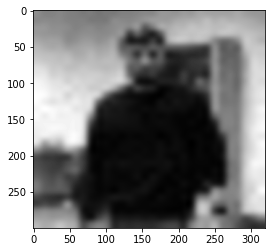

In [4]:
custom_patch = np.load("custom_patch_resized.npy")
custom_patch = torch.from_numpy(custom_patch)
plt.imshow(custom_patch, cmap='gray')

In [6]:
from patch_placement import place_patch

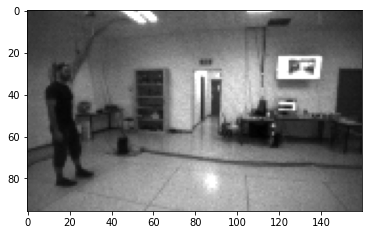

In [6]:
img = dataset.dataset.__getitem__(0)[0]
plt.imshow(img[0], cmap='gray')
# plt.savefig(path+'ori_image.jpg', dpi=200)

In [111]:
model(img.unsqueeze(0))

[tensor([[2.2261]], grad_fn=<UnsqueezeBackward0>),
 tensor([[1.5141]], grad_fn=<UnsqueezeBackward0>),
 tensor([[0.4459]], grad_fn=<UnsqueezeBackward0>),
 tensor([[0.5643]], grad_fn=<UnsqueezeBackward0>)]

In [7]:
transformation_matrix = [[[0.4, 0, -0.0], [0, 0.4, 0.4]]]
transformation_matrix = torch.tensor(transformation_matrix).float()

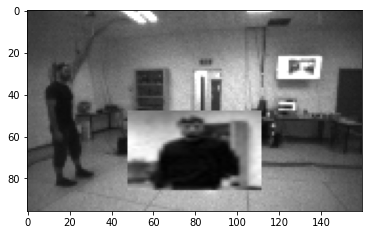

In [8]:
mod_img = place_patch(img, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)
plt.imshow(mod_img.detach().numpy()[0][0], cmap='gray')

In [8]:
import os
path = "eval_custom_patch/eval_translation/"
os.makedirs(path, exist_ok=True)

In [6]:
camera_intrinsics = np.load("camera_intrinsic.npy")
camera_extrinsics = np.load("full_translate.npy")

In [11]:
print(camera_intrinsics, camera_extrinsics)

[[ 89.52641296   0.          61.36280235]
 [  0.          66.52072144 134.92632966]
 [  0.           0.           1.        ]] [[ 0.18706529 -0.97502846  0.11969143 -0.19717897]
 [-0.66391182 -0.21528806 -0.71615094 -0.93262298]
 [ 0.72403568  0.05450242 -0.68760586  0.34973731]]


In [12]:
prediciton_ori = torch.stack(model(img.unsqueeze(0).float())).permute(1, 0, 2).squeeze(2).squeeze(0)

In [13]:
prediciton_ori.detach().clone()

tensor([2.2261, 1.5141, 0.4459, 0.5643])

In [14]:
target = prediciton_ori.detach().clone()
target[0] = 1.0
print(target)

tensor([1.0000, 1.5141, 0.4459, 0.5643])


In [121]:
target = prediciton_ori.detach().clone()
target[1] = -2
print(target)

tensor([ 2.2261, -2.0000,  0.4459,  0.5643])


In [111]:
target = prediciton_ori.detach().clone()
target[2] = 0.5
print(target)

tensor([2.2261, 1.5141, 0.5000, 0.5643])


In [22]:
all_outputs = []
count = 0

untargeted_losses = np.zeros((120,170))

x_min_losses = np.zeros((120, 170))
x_max_losses = np.zeros((120, 170))

y_min_losses = np.zeros((120, 170))
y_max_losses = np.zeros((120, 170))

z_min_losses = np.zeros((120, 170))
z_max_losses = np.zeros((120, 170))

prediciton_ori = torch.stack(model(img.unsqueeze(0).float())).permute(1, 0, 2).squeeze(2).squeeze(0)
target_x_min = prediciton_ori.detach().clone()
target_x_min[0] = 0.0

target_x_max = prediciton_ori.detach().clone()
target_x_max[0] = 4.0

target_y_min = prediciton_ori.detach().clone()
target_y_min[1] = -2.0

target_y_max = prediciton_ori.detach().clone()
target_y_max[1] = 2.0


target_z_min = prediciton_ori.detach().clone()
target_z_min[2] = -0.5

target_z_max = prediciton_ori.detach().clone()
target_z_max[2] = 0.5

# target = prediciton_ori.detach().clone()
# target[0] = 1.0

for tx in range(-80, 90):
    for ty in range(-60, 60):
        transformation_matrix = [[[0.4, 0, tx/100], [0, 0.4, ty/100]]]
        transformation_matrix = torch.tensor(transformation_matrix).float()
        mod_img = place_patch(img, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)


        prediction_mod = torch.stack(model(mod_img.float())).permute(1, 0, 2).squeeze(2).squeeze(0)

        loss = torch.dist(prediciton_ori, prediction_mod, p=2)
        # loss = -torch.dist(target, prediction_mod, p=2)
        untargeted_losses[ty+60][tx+80] = loss.detach().numpy()

        # x_max_losses[ty+60][tx+80] = -torch.dist(target_x_max, prediction_mod, p=2)
        # x_min_losses[ty+60][tx+80] = -torch.dist(target_x_min, prediction_mod, p=2)

        # y_max_losses[ty+60][tx+80] = -torch.dist(target_y_max, prediction_mod, p=2)
        # y_min_losses[ty+60][tx+80] = -torch.dist(target_y_min, prediction_mod, p=2)

        # z_max_losses[ty+60][tx+80] = -torch.dist(target_z_max, prediction_mod, p=2)
        # z_min_losses[ty+60][tx+80] = -torch.dist(target_z_min, prediction_mod, p=2)

        #all_losses.append([tx/100, ty/100, loss.detach().numpy()])
        
        # output = prediction_mod.detach().squeeze(0).numpy() # np.array([x[0,0].detach().numpy(), y[0,0].detach().numpy(), z[0,0].detach().numpy(), phi[0,0].detach().numpy()])
        # all_outputs.append(output)

        # u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((output[:3], np.array([1])))
        # img_x = u/w
        # img_y = v/w

        count += 1

        # plt.imshow(mod_img.detach().numpy()[0][0], cmap='gray')
        # plt.scatter(img_x, img_y)
        # plt.savefig(path+f"img_{count}.jpg", dpi=200)
        # plt.close()

# np.save(path+'y_min_l2dist', np.array(all_losses))
# np.save(path+'y_min_outputs', np.array(all_outputs))

# np.save(path+'x_max_l2dist', x_max_losses)
# np.save(path+'x_min_l2dist', x_min_losses)

# np.save(path+'y_max_l2dist', y_max_losses)
# np.save(path+'y_min_l2dist', y_min_losses)

# np.save(path+'z_max_l2dist', z_max_losses)
# np.save(path+'z_min_l2dist', z_min_losses)

np.save(path+'l2_untargeted', untargeted_losses)

/home/pia/Documents/Coding/.front-env/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [15]:
import os
path = "eval_custom_patch/eval_translation/avg_10/noise_patch/"
os.makedirs(path, exist_ok=True)

In [8]:
import os
path = "eval_custom_patch/eval_translation/fixed_ty/"
os.makedirs(path, exist_ok=True)

In [10]:
all_outputs = []
count = 0

# untargeted_losses = np.zeros((120,170))

# x_min_losses = np.zeros((120, 170))
# x_max_losses = np.zeros((120, 170))

# y_min_losses = np.zeros((120, 170))
# y_max_losses = np.zeros((120, 170))

# z_min_losses = np.zeros((120, 170))
# z_max_losses = np.zeros((120, 170))

x_min_losses = []
x_max_losses = []

y_min_losses = []
y_max_losses = []

z_min_losses = []
z_max_losses = []

prediciton_ori = torch.stack(model(img.unsqueeze(0).float())).permute(1, 0, 2).squeeze(2).squeeze(0)
target_x_min = prediciton_ori.detach().clone()
target_x_min[0] = 0.0

target_x_max = prediciton_ori.detach().clone()
target_x_max[0] = 4.0

target_y_min = prediciton_ori.detach().clone()
target_y_min[1] = -2.0

target_y_max = prediciton_ori.detach().clone()
target_y_max[1] = 2.0


target_z_min = prediciton_ori.detach().clone()
target_z_min[2] = -0.5

target_z_max = prediciton_ori.detach().clone()
target_z_max[2] = 0.5

# target = prediciton_ori.detach().clone()
# target[0] = 1.0

ty = -0.11

# for i in range(10):
#     noise = torch.distributions.normal.Normal(loc=0.0, scale=10.).sample(img.shape)   #loc == mu, scale == sigma
for tx in range(-80, 80):
    # for ty in range(-60, 60):
        transformation_matrix = [[[0.4, 0, tx/100], [0, 0.4, ty/100]]]
        transformation_matrix = torch.tensor(transformation_matrix).float()
        mod_img = place_patch(img, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)
        # mod_img += noise


        prediction_mod = torch.stack(model(mod_img.float())).permute(1, 0, 2).squeeze(2).squeeze(0)

        # loss = torch.dist(prediciton_ori, prediction_mod, p=2)
        # loss = torch.dist(target, prediction_mod, p=2)
        # untargeted_losses[ty+60][tx+80] = loss.detach().numpy()


        x_max_losses.append([tx/100, ty/100, torch.dist(target_x_max[0], prediction_mod[0], p=2).detach().cpu().numpy()])
        x_min_losses.append([tx/100, ty/100, torch.dist(target_x_min[0], prediction_mod[0], p=2).detach().cpu().numpy()])

        y_max_losses.append([tx/100, ty/100, torch.dist(target_y_max[1], prediction_mod[1], p=2).detach().cpu().numpy()])
        y_min_losses.append([tx/100, ty/100, torch.dist(target_y_min[1], prediction_mod[1], p=2).detach().cpu().numpy()])

        z_max_losses.append([tx/100, ty/100, torch.dist(target_z_max[2], prediction_mod[2], p=2).detach().cpu().numpy()])
        z_min_losses.append([tx/100, ty/100, torch.dist(target_z_min[2], prediction_mod[2], p=2).detach().cpu().numpy()])
        
        # x_max_losses[ty+60][tx+80] = -torch.dist(target_x_max, prediction_mod, p=2)
        # x_min_losses[ty+60][tx+80] = -torch.dist(target_x_min, prediction_mod, p=2)

        # y_max_losses[ty+60][tx+80] = -torch.dist(target_y_max, prediction_mod, p=2)
        # y_min_losses[ty+60][tx+80] = -torch.dist(target_y_min, prediction_mod, p=2)

        # z_max_losses[ty+60][tx+80] = -torch.dist(target_z_max, prediction_mod, p=2)
        # z_min_losses[ty+60][tx+80] = -torch.dist(target_z_min, prediction_mod, p=2)

        #all_losses.append([tx/100, ty/100, loss.detach().numpy()])
        
        output = prediction_mod.detach().squeeze(0).numpy() # np.array([x[0,0].detach().numpy(), y[0,0].detach().numpy(), z[0,0].detach().numpy(), phi[0,0].detach().numpy()])
        all_outputs.append(output)

        # u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((output[:3], np.array([1])))
        # img_x = u/w
        # img_y = v/w

        count += 1

        # plt.imshow(mod_img.detach().numpy()[0][0], cmap='gray')
        # plt.scatter(img_x, img_y)
        # plt.savefig(path+f"img_{tx/100}_{ty/100}.jpg", dpi=200)
        # plt.close()

# np.save(path+'y_min_l2dist', np.array(all_losses))
np.save(path+'all_predictions', np.array(all_outputs))

np.save(path+'x_max_l2dist', x_max_losses)
np.save(path+'x_min_l2dist', x_min_losses)

np.save(path+'y_max_l2dist', y_max_losses)
np.save(path+'y_min_l2dist', y_min_losses)

np.save(path+'z_max_l2dist', z_max_losses)
np.save(path+'z_min_l2dist', z_min_losses)

# np.save(path+'l2_untargeted', untargeted_losses)

In [67]:
all_losses.shape

(120, 170)

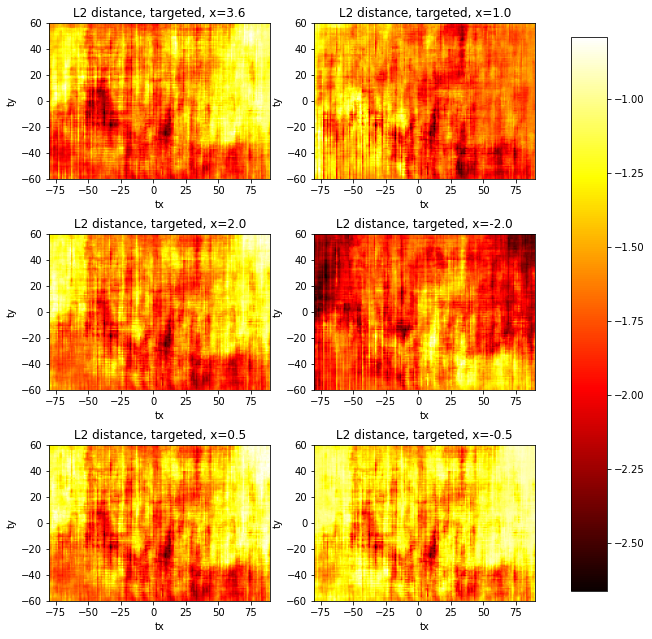

In [149]:
fig, ax = plt.subplots(3, 2, figsize=(10,11))
ax[0][0].imshow(x_max_losses, cmap='hot', extent=[-80,90,60,-60])
ax[0][1].imshow(x_min_losses, cmap='hot', extent=[-80,90,60,-60])
ax[1][0].imshow(y_max_losses, cmap='hot', extent=[-80,90,60,-60])
ax[1][1].imshow(y_min_losses, cmap='hot', extent=[-80,90,60,-60])
ax[2][0].imshow(z_max_losses, cmap='hot', extent=[-80,90,60,-60])
im = ax[2][1].imshow(z_min_losses, cmap='hot', extent=[-80,90,60,-60])


ax[0][0].set_xlabel('tx')
ax[0][1].set_xlabel('tx')
ax[1][0].set_xlabel('tx')
ax[1][1].set_xlabel('tx')
ax[2][0].set_xlabel('tx')
ax[2][1].set_xlabel('tx')
ax[0][0].set_ylabel('ty')
ax[0][1].set_ylabel('ty')
ax[1][0].set_ylabel('ty')
ax[1][1].set_ylabel('ty')
ax[2][0].set_ylabel('ty')
ax[2][1].set_ylabel('ty')

ax[0][0].set_title('L2 distance, targeted, x=3.6')
ax[0][1].set_title('L2 distance, targeted, x=1.0')

ax[1][0].set_title('L2 distance, targeted, y=2.0')
ax[1][1].set_title('L2 distance, targeted, y=-2.0')

ax[2][0].set_title('L2 distance, targeted, z=0.5')
ax[2][1].set_title('L2 distance, targeted, z=-0.5')


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

# fig.tight_layout()

plt.savefig(path+'all_targeted.jpg', dpi=200)

In [178]:
np.max(x_max_losses)

-1.1262564659118652

/home/pia/Documents/Coding/.front-env/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


[2.062441   1.2642801  0.23144595 0.56899464]
[2.2260566  1.5140656  0.44586247 0.5643381 ]
tensor(-0.7901, grad_fn=<NegBackward0>)


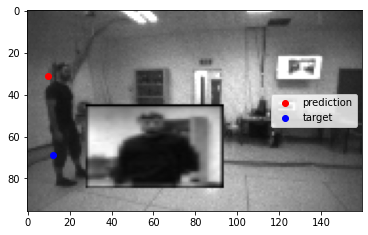

In [197]:
ty_pos, tx_pos = np.unravel_index(np.argmax(z_min_losses), y_max_losses.shape) 

transformation_matrix = [[[0.4, 0, (tx_pos-80)/100], [0, 0.4, (ty_pos-60)/100]]]
transformation_matrix = torch.tensor(transformation_matrix).float()
mod_img = place_patch(img, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)
plt.imshow(mod_img.detach().numpy()[0][0], cmap='gray')

prediction_mod = torch.stack(model(mod_img.float())).permute(1, 0, 2).squeeze(2).squeeze(0)
output = prediction_mod.detach().squeeze(0).numpy()
print(output)

u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((output[:3], np.array([1])))
img_x = u/w
img_y = v/w

plt.scatter(img_x, img_y, color='red', label='prediction')

# prediciton_ori = torch.stack(model(img.unsqueeze(0).float())).permute(1, 0, 2).squeeze(2).unsqueeze(0)
output_ori = prediciton_ori.detach().squeeze(0).squeeze(0).numpy()
print(output_ori)
print(-torch.dist(target_z_min, prediction_mod))
# u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((output_ori[:3], np.array([1])))
u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((target_z_min.numpy()[:3], np.array([1])))
img_x = u/w
img_y = v/w

plt.scatter(img_x, img_y, color='blue', label='target')
plt.legend(loc='right')
plt.savefig(path+'z_min_max_placed.jpg', dpi=200)

Text(0.5, 1.0, 'l2 distance, targeted, x=3.6')

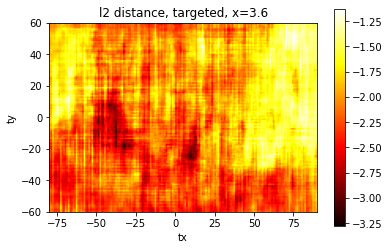

In [125]:
plt.imshow(x_max_losses, cmap='hot', extent=[-80,90,-60,60])
plt.colorbar()
plt.xlabel('tx')
plt.ylabel('ty')
plt.title("l2 distance, targeted, x=3.6")
#plt.savefig(path+"z_max_targeted_loss.jpg", dpi=200)

In [198]:
losses_untargeted = np.load(path+'losses_untargeted.npy')

In [199]:
losses_untargeted.shape

(20400, 3)

In [211]:
torch.stack(model(img.unsqueeze(0).float())).permute(1, 0, 2).squeeze(2).squeeze(0)

tensor([2.2261, 1.5141, 0.4459, 0.5643], grad_fn=<SqueezeBackward1>)

[ 1.2842147  -0.71196073  0.41247308 -0.08204769]
[2.2260566  1.5140656  0.44586247 0.5643381 ]


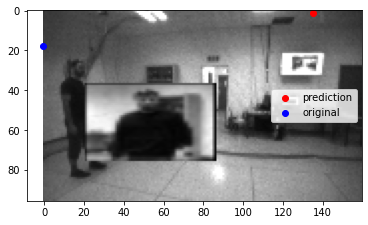

In [215]:
ty_pos, tx_pos = np.unravel_index(np.argmax(untargeted_losses), y_max_losses.shape) 

transformation_matrix = [[[0.4, 0, (tx_pos-80)/100], [0, 0.4, (ty_pos-60)/100]]]
transformation_matrix = torch.tensor(transformation_matrix).float()
mod_img = place_patch(img, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)
plt.imshow(mod_img.detach().numpy()[0][0], cmap='gray')

prediction_mod = torch.stack(model(mod_img.float())).permute(1, 0, 2).squeeze(2).squeeze(0)
output = prediction_mod.detach().squeeze(0).numpy()
print(output)

u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((output[:3], np.array([1])))
img_x = u/w
img_y = v/w

plt.scatter(img_x, img_y, color='red', label='prediction')

prediciton_ori = torch.stack(model(img.unsqueeze(0).float())).permute(1, 0, 2).squeeze(2).unsqueeze(0)
output_ori = prediciton_ori.detach().squeeze(0).squeeze(0).numpy()
print(output_ori)
#print(-torch.dist(target_z_min, prediction_mod))
u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((output_ori[:3], np.array([1])))
#u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((target_z_min.numpy()[:3], np.array([1])))
img_x = u/w
img_y = v/w

plt.scatter(img_x, img_y, color='blue', label='original')
plt.legend(loc='right')
plt.savefig(path+'untargeted_placed.jpg', dpi=200)

In [46]:
images = np.load('/home/pia/Documents/Coding/adversarial_frontnet/eval/only_translation/train_images.npy')

In [47]:
images.shape

(5001, 96, 160)

In [48]:
losses = np.load('/home/pia/Documents/Coding/adversarial_frontnet/eval/only_translation/losses_test.npy')

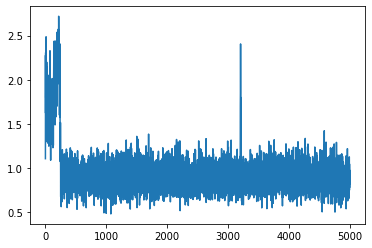

In [50]:
plt.plot(losses)

In [51]:
vectors = np.load('/home/pia/Documents/Coding/adversarial_frontnet/eval/only_translation/translation_vectors.npy')

In [60]:
vectors[1200]

array([0.10594101, 1.536905  ], dtype=float32)

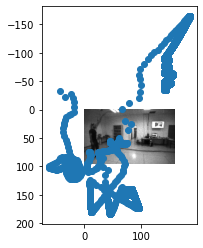

In [62]:
plt.imshow(img[0], cmap='gray')
plt.scatter(([0.80, 0.48] + vectors[i])*100)

[-0.42742062 -0.32001007]
[37.25793839 15.9989934 ]


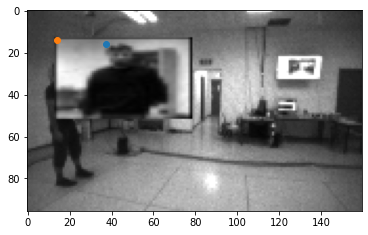

In [93]:
i = 0
plt.imshow(images[i], cmap='gray')
print(vectors[i])
print(([0.8, 0.48] + vectors[i])*100)
img_vec = ([0.8, 0.48] + vectors[i])*100
plt.scatter(img_vec[0], img_vec[1])
plt.scatter(14, 14)

In [95]:
vectors[0]

array([-0.42742062, -0.32001007], dtype=float32)

In [143]:
translation_vector = torch.tensor([0.0, 0.0])
print(translation_vector, translation_vector.shape)

tensor([0., 0.]) torch.Size([2])


In [144]:
rotation_matrix = torch.zeros((2,2))
rotation_matrix[0,0] = 0.5
rotation_matrix[1,1] = 0.5
transformation_matrix = torch.cat([rotation_matrix, translation_vector.unsqueeze(0)]).mT
transformation_matrix = transformation_matrix.unsqueeze(0)

In [145]:
print(transformation_matrix, transformation_matrix.shape)

tensor([[[0.5000, 0.0000, 0.0000],
         [0.0000, 0.5000, 0.0000]]]) torch.Size([1, 2, 3])


In [146]:
zero_image = place_patch(img.unsqueeze(0), custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)

/home/pia/Documents/Coding/.front-env/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [132]:
160*0.4

64.0

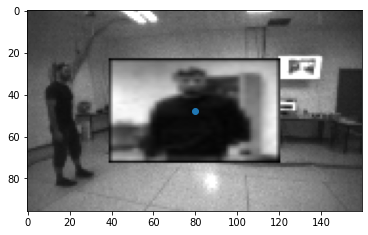

In [147]:
plt.imshow(zero_image[0][0].detach().numpy(), cmap='gray')
plt.scatter(80, 48)

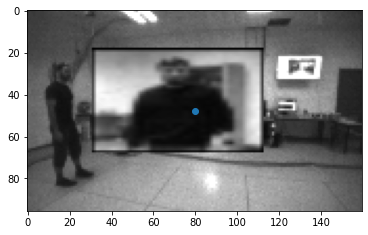

In [149]:
plt.imshow(new_image[0][0].detach().numpy(), cmap='gray')
plt.scatter(80, 48)

In [ ]:
# optimierung fixe tx / ty

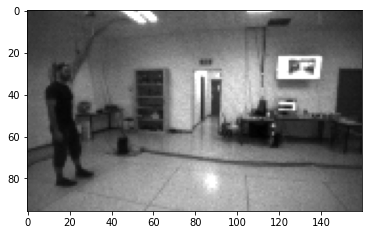

In [38]:
image = dataset.dataset.__getitem__(0)[0].unsqueeze(0)
plt.imshow(image[0][0], cmap='gray')

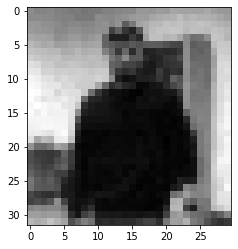

In [57]:
plt.imshow(custom_patch, cmap='gray')

In [42]:
custom_patch.shape

torch.Size([32, 30])

In [34]:
tx = torch.rand(1).requires_grad_(True)
ty = torch.tensor([-0.12])

translation_vector = torch.stack([tx, ty])
print(translation_vector, translation_vector.shape)

tensor([[ 0.7093],
        [-0.1200]], grad_fn=<StackBackward0>) torch.Size([2, 1])


In [35]:
rotation_matrix = torch.zeros(1, 2, 2)#.to(transformation_matrix.device)
rotation_matrix[0][0][0] = 0.4
rotation_matrix[0][1][1] = 0.4

In [37]:
rotation_matrix.shape

torch.Size([1, 2, 2])

In [40]:
full_transform = torch.cat((rotation_matrix, translation_vector.unsqueeze(0)), dim=2)
print(full_transform)

tensor([[[ 0.4000,  0.0000,  0.7093],
         [ 0.0000,  0.4000, -0.1200]]], grad_fn=<CatBackward0>)


In [19]:
path = "eval_custom_patch/eval_translation/fixed_ty/"
os.makedirs(path, exist_ok=True)

In [81]:
all_l2 = []

for ty in range(-60, 60):
    tx = torch.tensor([-0.13]).requires_grad_(True)
    ty = torch.tensor([ty/100])
    translation_vector = torch.stack([tx, ty]).unsqueeze(0)
    full_transform = torch.cat((rotation_matrix, translation_vector), dim=2)
    # print(full_transform)

    new_image = place_patch(image, custom_patch.unsqueeze(0).unsqueeze(0), full_transform)#transformation_matrix)
    # new_image += torch.distributions.normal.Normal(loc=0.0, scale=10.).sample(new_image.shape).to(new_image.device)   #loc == mu, scale == sigma
    new_image.data.clamp_(0., 255.)

    prediction = torch.concat(model(new_image)).squeeze(1)
    loss = torch.dist(prediction[1], target, p=2)
    all_l2.append([ty.detach().clone().numpy()[0], float(loss.detach().clone().numpy())])
# print(prediction)
# print()
np.save(path+'all_distances_ty', np.array(all_l2))
# np.save(path+'vectors', vectors)
# np.save(path+'predicitons', predictions)

/home/pia/Documents/Coding/.front-env/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [82]:
all_l2[:10]

[[-0.6, 0.9671659469604492],
 [-0.59, 0.9841690063476562],
 [-0.58, 0.9474549293518066],
 [-0.57, 0.9246866703033447],
 [-0.56, 0.8200701475143433],
 [-0.55, 0.8047475814819336],
 [-0.54, 0.7737852334976196],
 [-0.53, 0.7489832639694214],
 [-0.52, 0.8077203035354614],
 [-0.51, 0.6825058460235596]]

In [6]:
import os
path = "eval_custom_patch/eval_translation/fixed_tx/"
os.makedirs(path, exist_ok=True)

In [25]:
# def targeted_attack(image, patch, target, model, scaling_factor, translation_vector, path="eval/targeted/"):
#     # initialize optimizer

tx = torch.tensor([0.25]).requires_grad_(True)
ty = torch.tensor([-0.12])

print(tx, ty)

opt = torch.optim.Adam([tx], lr=1e-2)
prediction_ori = torch.concat(model(image)).squeeze(1)


rotation_matrix = torch.zeros(1, 2, 2)#.to(transformation_matrix.device)
rotation_matrix[0][0][0] = 0.4
rotation_matrix[0][1][1] = 0.4

print(rotation_matrix)

# identity = torch.eye(2).to(scaling_factor.device)

target = torch.tensor(2.0)

losses = []
vectors = []
predictions = []

loss = 3.

i = 0.
try:
    while i <= 500:
        # i += 1
        # vectors.append(transformation_matrix.view(-1).detach().cpu().numpy())
        # tanh_trans = torch.tanh(translation_vector).unsqueeze(0).unsqueeze(0)
        # sig_scale = torch.sigmoid(scaling_factor)
        # vectors.append(tanh_matrix.view(-1).detach().cpu().numpy())

        # vectors.append([scaling_factortranslation_vector.view(-1).detach().cpu().numpy()])

        # rotation_matrix = (identity * sig_scale).unsqueeze(0)

        
        # full_transform = torch.cat((rotation_matrix, tanh_trans.mT), dim=2)
        # vectors.append([sig_scale.detach().cpu().numpy(), *tanh_trans.detach().cpu().numpy()])
        # print(ty.detach().numpy())
        vectors.append(tx.detach().clone().item())#.numpy())
        # print(vectors[int(i)])
        translation_vector = torch.stack([tx, ty]).unsqueeze(0)
        full_transform = torch.cat((rotation_matrix, translation_vector), dim=2)
        # print(full_transform)

        new_image = place_patch(image, custom_patch.unsqueeze(0).unsqueeze(0), full_transform)#transformation_matrix)
        # new_image += torch.distributions.normal.Normal(loc=0.0, scale=10.).sample(new_image.shape).to(new_image.device)   #loc == mu, scale == sigma
        new_image.data.clamp_(0., 255.)

        prediction = torch.concat(model(new_image)).squeeze(1)
        predictions.append(prediction.detach().cpu().numpy())
        #print("Distance original and current prediction: ",  torch.dist(prediction[1], prediction_ori[1], p=2))
        loss = torch.dist(prediction[1], target, p=2)
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.detach().cpu().numpy())#[loss_x.detach().cpu().numpy(), loss_y.detach().cpu().numpy(), loss_z.detach().cpu().numpy(), loss.detach().cpu().numpy()])


        i += 1

        
        if i % 10 == 0:
            print("step %d, loss %.6f" % (i, loss.detach().cpu().numpy()))
            # print("original value: ", prediction_ori[1].detach().cpu().numpy())
            print("prediciton: ", prediction[0].detach().cpu().numpy())#, ", target: ", target[1].detach().cpu().numpy())
            print("matrix: ", full_transform.view(-1).detach().cpu().numpy())
            # np.save(path+'test_image_'+str(i), new_image.detach().cpu().numpy())
except KeyboardInterrupt:
    print("Aborting optimization...")    

print("Bing!")
# print("Best loss: ", np.min(losses), np.argmin(losses))
# print("Best scale factor & translation vector: ", vectors[np.argmin(losses)])
# print("Best prediciton: ", predictions[np.argmin(losses)])

# print(vectors[:30])

np.save(path+'losses_6', losses)
np.save(path+'vectors_6', vectors)
np.save(path+'predicitons_6', predictions)



    # return patch, vectors[np.argmin(losses)], losses

tensor([0.2500], requires_grad=True) tensor([-0.1200])
tensor([[[0.4000, 0.0000],
         [0.0000, 0.4000]]])
step 10, loss 1.178444
prediciton:  2.0085087
matrix:  [ 0.4        0.         0.2676146  0.         0.4       -0.12     ]
step 20, loss 1.046544
prediciton:  2.0712872
matrix:  [ 0.4         0.          0.26811004  0.          0.4        -0.12      ]
step 30, loss 1.048095
prediciton:  2.0716987
matrix:  [ 0.4         0.          0.26816335  0.          0.4        -0.12      ]
step 40, loss 1.176697
prediciton:  2.0110152
matrix:  [ 0.4         0.          0.26781407  0.          0.4        -0.12      ]
step 50, loss 1.213941
prediciton:  1.9746002
matrix:  [ 0.4        0.         0.2638969  0.         0.4       -0.12     ]
step 60, loss 1.185934
prediciton:  1.9953418
matrix:  [ 0.4         0.          0.26664233  0.          0.4        -0.12      ]
step 70, loss 1.188033
prediciton:  1.9909089
matrix:  [ 0.4         0.          0.26623693  0.          0.4        -0.12      

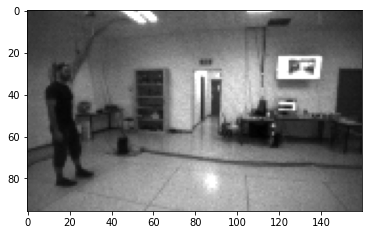

In [194]:
# optimierung skalierungsfaktor
image = dataset.dataset.__getitem__(0)[0].unsqueeze(0)
plt.imshow(image[0][0], cmap='gray')

In [210]:
import os
path = "eval_custom_patch/eval_translation/scaling/4.0/"
os.makedirs(path, exist_ok=True)

In [211]:
all_l2 = []

tx = torch.tensor([0.0])#.requires_grad_(True)
ty = torch.tensor([0.0])
translation_vector = torch.stack([tx, ty]).unsqueeze(0)

identity = torch.eye(2)


target = torch.tensor(4.0)

for scaling_factor in range(1, 1001):

    rotation_matrix = (identity * scaling_factor/1000.).unsqueeze(0)
    full_transform = torch.cat((rotation_matrix, translation_vector), dim=2)
    # print(full_transform)

    new_image = place_patch(image, custom_patch.unsqueeze(0).unsqueeze(0), full_transform)#transformation_matrix)
    # new_image += torch.distributions.normal.Normal(loc=0.0, scale=10.).sample(new_image.shape).to(new_image.device)   #loc == mu, scale == sigma
    new_image.data.clamp_(0., 255.)

    prediction = torch.concat(model(new_image)).squeeze(1)
    loss = torch.dist(prediction[0], target, p=2)
    all_l2.append([scaling_factor/1000., float(loss.detach().clone().numpy())])
# print(prediction)
# print()
np.save(path+'all_distances_4', np.array(all_l2))

/home/pia/Documents/Coding/.front-env/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [214]:
# def targeted_attack(image, patch, target, model, scaling_factor, translation_vector, path="eval/targeted/"):
#     # initialize optimizer

tx = torch.tensor([0.])
ty = torch.tensor([0.])

scaling_factor = torch.tensor([0.5]).requires_grad_(True)

print(tx, ty)

translation_vector = torch.stack([tx, ty]).unsqueeze(0)

opt = torch.optim.Adam([scaling_factor], lr=1e-1)
prediction_ori = torch.concat(model(image)).squeeze(1)


# rotation_matrix = torch.zeros(1, 2, 2)#.to(transformation_matrix.device)
# rotation_matrix[0][0][0] = 0.4
# rotation_matrix[0][1][1] = 0.4

# print(rotation_matrix)

identity = torch.eye(2)#.to(scaling_factor.device)

target = torch.tensor(4.0)

losses = []
vectors = []
predictions = []

loss = 3.

i = 0.
try:
    while i <= 500:
        # i += 1
        # vectors.append(transformation_matrix.view(-1).detach().cpu().numpy())
        # tanh_trans = torch.tanh(translation_vector).unsqueeze(0).unsqueeze(0)
        # sig_scale = torch.sigmoid(scaling_factor)
        # vectors.append(tanh_matrix.view(-1).detach().cpu().numpy())

        # vectors.append([scaling_factortranslation_vector.view(-1).detach().cpu().numpy()])

        rotation_matrix = (identity * scaling_factor).unsqueeze(0)#sig_scale).unsqueeze(0)

        
        # full_transform = torch.cat((rotation_matrix, tanh_trans.mT), dim=2)
        # vectors.append([sig_scale.detach().cpu().numpy(), *tanh_trans.detach().cpu().numpy()])
        # print(ty.detach().numpy())
        vectors.append(scaling_factor.detach().clone().item())#.numpy())
        # print(vectors[int(i)])
        # translation_vector = torch.stack([tx, ty]).unsqueeze(0)
        full_transform = torch.cat((rotation_matrix, translation_vector), dim=2)
        # print(full_transform)

        new_image = place_patch(image, custom_patch.unsqueeze(0).unsqueeze(0), full_transform)#transformation_matrix)
        # new_image += torch.distributions.normal.Normal(loc=0.0, scale=10.).sample(new_image.shape).to(new_image.device)   #loc == mu, scale == sigma
        new_image.data.clamp_(0., 255.)

        prediction = torch.concat(model(new_image)).squeeze(1)
        predictions.append(prediction.detach().cpu().numpy())
        #print("Distance original and current prediction: ",  torch.dist(prediction[1], prediction_ori[1], p=2))
        loss = torch.dist(prediction[0], target, p=2)
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.detach().cpu().numpy())#[loss_x.detach().cpu().numpy(), loss_y.detach().cpu().numpy(), loss_z.detach().cpu().numpy(), loss.detach().cpu().numpy()])


        i += 1

        
        if i % 10 == 0:
            print("step %d, loss %.6f" % (i, loss.detach().cpu().numpy()))
            # print("original value: ", prediction_ori[1].detach().cpu().numpy())
            print("prediciton: ", prediction[0].detach().cpu().numpy())#, ", target: ", target[1].detach().cpu().numpy())
            print("matrix: ", full_transform.view(-1).detach().cpu().numpy())
            # np.save(path+'test_image_'+str(i), new_image.detach().cpu().numpy())
except KeyboardInterrupt:
    print("Aborting optimization...")    

print("Bing!")
# print("Best loss: ", np.min(losses), np.argmin(losses))
# print("Best scale factor & translation vector: ", vectors[np.argmin(losses)])
# print("Best prediciton: ", predictions[np.argmin(losses)])

# print(vectors[:30])

np.save(path+'losses_1e-1', losses)
np.save(path+'vectors_1e-1', vectors)
np.save(path+'predicitons_1e-1', predictions)



    # return patch, vectors[np.argmin(losses)], losses

tensor([0.]) tensor([0.])
step 10, loss 2.638015
prediciton:  1.3619846
matrix:  [0.62510246 0.         0.         0.         0.62510246 0.        ]
step 20, loss 2.595842
prediciton:  1.4041584
matrix:  [0.6216114 0.        0.        0.        0.6216114 0.       ]
step 30, loss 2.792796
prediciton:  1.2072041
matrix:  [0.605347 0.       0.       0.       0.605347 0.      ]
step 40, loss 2.407604
prediciton:  1.5923955
matrix:  [0.5340182 0.        0.        0.        0.5340182 0.       ]
step 50, loss 2.410249
prediciton:  1.5897505
matrix:  [0.5342951 0.        0.        0.        0.5342951 0.       ]
step 60, loss 2.633478
prediciton:  1.3665221
matrix:  [0.6712403 0.        0.        0.        0.6712403 0.       ]
step 70, loss 2.609158
prediciton:  1.3908426
matrix:  [0.5638602 0.        0.        0.        0.5638602 0.       ]
step 80, loss 2.780978
prediciton:  1.2190216
matrix:  [0.60605633 0.         0.         0.         0.60605633 0.        ]
step 90, loss 2.651455
predicito

In [26]:
# tests with base image without person

In [7]:
import os
path = "eval_custom_patch/eval_translation/clear_img/new_plots/"
os.makedirs(path, exist_ok=True)

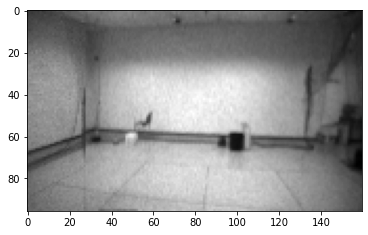

In [8]:
from matplotlib import image

clear_img = image.imread('clear_img.jpg')
clear_img = np.array(clear_img)
plt.imshow(clear_img, cmap='gray')

In [9]:
clear_img_t = torch.FloatTensor(clear_img).unsqueeze(0).unsqueeze(0)

In [11]:
prediction_mod = torch.stack(model(clear_img_t)).permute(1, 0, 2).squeeze(2).squeeze(0)
output = prediction_mod.detach().squeeze(0).numpy()
print(output)

u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((output[:3], np.array([1])))
img_x = u/w
img_y = v/w

print(img_x, img_y)

[2.1957855  0.9463753  0.20137767 0.56742334]
28.258644079717094 36.603804379873964


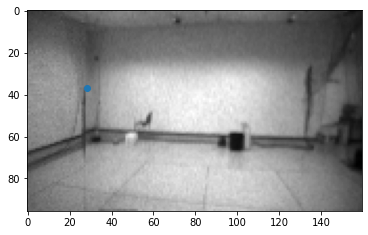

In [12]:
plt.imshow(clear_img, cmap='gray')
plt.scatter(img_x, img_y)

In [10]:
full_transform = [[[0.4, 0, 0], [0, 0.4, 0]]]
full_transform = torch.tensor(full_transform).float()

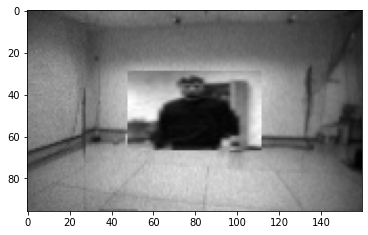

In [11]:
new_image = place_patch(clear_img_t, custom_patch.unsqueeze(0).unsqueeze(0), full_transform)
plt.imshow(new_image.detach().numpy()[0][0], cmap='gray')

[ 1.3129768  -0.0839153   0.28482985 -0.11607931]
74.73899487171721 14.564932186946344


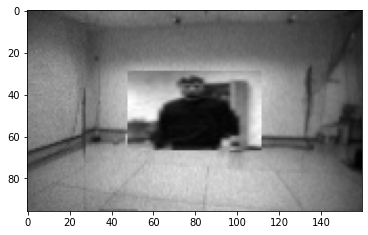

In [40]:
prediction_mod = torch.stack(model(new_image)).permute(1, 0, 2).squeeze(2).squeeze(0)
output = prediction_mod.detach().squeeze(0).numpy()
print(output)

u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((output[:3], np.array([1])))
img_x = u/w
img_y = v/w

print(img_x, img_y)

plt.imshow(new_image.detach().numpy()[0][0], cmap='gray')
# plt.scatter(img_x, img_y, label='projected prediction')
# plt.legend()
plt.savefig(path+'clear_img_patch_base.jpg', dpi=200)

In [45]:
full_transform[0, 0, 2] = 0#torch.rand_like(full_transform[0, 0, 2])
full_transform[0, 1, 2] = -0.4#torch.rand_like(full_transform[0, 1, 2])
print(full_transform)

tensor([[[ 0.4000,  0.0000,  0.0000],
         [ 0.0000,  0.4000, -0.4000]]])


[1.708477   0.08034981 0.43078685 0.21106073]
67.97483349926017 12.010087899086692


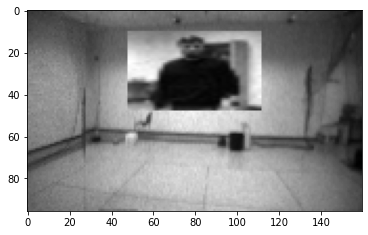

In [46]:
new_image = place_patch(clear_img_t, custom_patch.unsqueeze(0).unsqueeze(0), full_transform)
prediction_mod = torch.stack(model(new_image)).permute(1, 0, 2).squeeze(2).squeeze(0)
output = prediction_mod.detach().squeeze(0).numpy()
print(output)

u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((output[:3], np.array([1])))
img_x = u/w
img_y = v/w

print(img_x, img_y)


plt.imshow(new_image.detach().numpy()[0][0], cmap='gray')
# plt.savefig("eval_custom_patch/eval_translation/clear_img/clear_img_patch.jpg", dpi=200)
# plt.scatter(img_x, img_y, label='projected prediction')
# plt.legend()
plt.savefig(path+'clear_img_patch_3.jpg', dpi=200)

In [26]:
prediction_mod[1].item()

0.06351390480995178

In [47]:
ty = 0.

all_y = []

for tx in range(-100, 101):
    transformation_matrix = [[[0.4, 0, tx/100.], [0, 0.4, ty/100.]]]
    transformation_matrix = torch.tensor(transformation_matrix).float()
    mod_img = place_patch(clear_img_t, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)
    # mod_img += noise


    prediction_mod = torch.stack(model(mod_img.float())).permute(1, 0, 2).squeeze(2).squeeze(0)
    all_y.append(prediction_mod.detach()[1].item())

In [48]:
len(all_y)

201

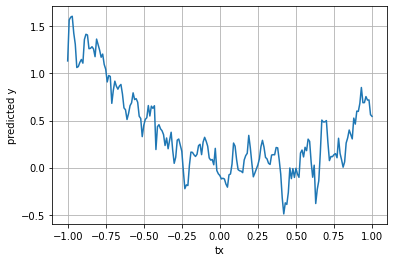

In [50]:
plt.plot(np.linspace(-1, 1, num=201), all_y)
plt.grid('True')
plt.xlabel('tx')
plt.ylabel('predicted y')
plt.savefig(path+'base_tx_only.jpg', dpi=200)

In [12]:
batch_clear_img = []
for i in range(10):
    batch_clear_img.append(clear_img_t[0])

batch_clear_img = torch.stack(batch_clear_img)

In [52]:
tx = 0.

all_z = []

for ty in range(-100, 101):
    transformation_matrix = [[[0.4, 0, tx/100.], [0, 0.4, ty/100.]]]
    transformation_matrix = torch.tensor(transformation_matrix).float()
    mod_img = place_patch(clear_img_t, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)
    # mod_img += noise


    prediction_mod = torch.stack(model(mod_img.float())).permute(1, 0, 2).squeeze(2).squeeze(0)
    all_z.append(prediction_mod.detach()[2].item())

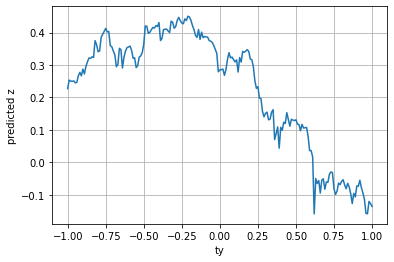

In [54]:
plt.plot(np.linspace(-1, 1, num=201), all_z)
plt.grid('True')
plt.xlabel('ty')
plt.ylabel('predicted z')
plt.savefig(path+'base_ty_only.jpg', dpi=200)

In [13]:
noisy_batch = batch_clear_img.clone()

for i in range(10, 110, 10):
    noise = torch.distributions.normal.Normal(loc=0.0, scale=i).sample(batch_clear_img[0].shape)   #loc == mu, scale == sigma
    noisy_batch[int((i-10)/10)] += noise
    noisy_batch[int((i-10)/10)].clamp_(0., 255.)

In [52]:
transformation_matrix = [[[0.4, 0, tx/100.], [0, 0.4, ty/100.]]]
transformation_matrix = torch.tensor(transformation_matrix).float()
mod_img = place_patch(noisy_batch, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)
prediction_mod = torch.stack(model(mod_img.float())).permute(1, 0, 2).squeeze(2).squeeze(0)

In [69]:
noisy_batch.shape

torch.Size([10, 1, 96, 160])

In [70]:
tx = 0.

all_z_noisy = []

for ty in range(-100, 101):
    transformation_matrix = [[[0.4, 0, tx/100.], [0, 0.4, ty/100.]]]
    transformation_matrix = torch.tensor(transformation_matrix).float()
    mod_img = place_patch(noisy_batch, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)
    # mod_img += noise


    prediction_mod = torch.stack(model(mod_img.float())).permute(1, 0, 2).squeeze(2).squeeze(0)
    all_z_noisy.append(prediction_mod[..., 2].detach().clone().numpy())

In [71]:
prediction_mod = torch.stack(model(mod_img.float())).permute(1, 0, 2).squeeze(2).squeeze(0)
print(prediction_mod)

tensor([[ 1.4393,  0.0771, -0.1493,  0.1620],
        [ 1.2723, -0.1365, -0.0538, -0.0812],
        [ 1.0922, -0.2436,  0.1085,  0.0638],
        [ 1.0448, -0.4942,  0.3049, -0.2572],
        [ 0.9021, -0.4518,  0.3198, -0.2184],
        [ 0.8388, -0.0167,  0.3217, -0.1634],
        [ 0.7281,  0.0539,  0.3328, -0.0119],
        [ 0.8734, -0.0827,  0.3716, -0.0810],
        [ 0.6484,  0.1321,  0.3872, -0.1772],
        [ 0.7578, -0.0775,  0.3236, -0.0849]], grad_fn=<SqueezeBackward1>)


In [72]:
np.array(all_z_noisy).T.shape

(10, 201)

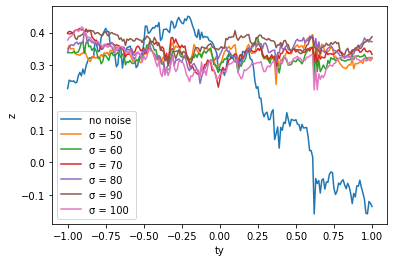

In [83]:
plt.plot(np.linspace(-1, 1, num=201), all_z, label='no noise')
plt.plot(np.linspace(-1, 1, num=201), np.array(all_z_noisy)[..., 4:], label=['σ = 50', 'σ = 60', 'σ = 70', 'σ = 80', 'σ = 90', 'σ = 100'])#, 'σ = 60', 'σ = 70', 'σ = 80', 'σ = 90', 'σ = 100'])    #['σ = 10', 'σ = 20', 'σ = 30', 'σ = 40'])#, 'σ = 50'])#, 'σ = 60', 'σ = 70', 'σ = 80', 'σ = 90', 'σ = 100'])
plt.legend()
plt.xlabel('ty')
plt.ylabel('z')
plt.savefig(path+'noisy_tx_only50-100.jpg', dpi=200)

In [84]:
ty = 0.

all_y_noisy = []

for tx in range(-100, 101):
    transformation_matrix = [[[0.4, 0, tx/100.], [0, 0.4, ty/100.]]]
    transformation_matrix = torch.tensor(transformation_matrix).float()
    mod_img = place_patch(noisy_batch, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)
    # mod_img += noise


    prediction_mod = torch.stack(model(mod_img.float())).permute(1, 0, 2).squeeze(2).squeeze(0)
    all_y_noisy.append(prediction_mod[..., 1].detach().clone().numpy())

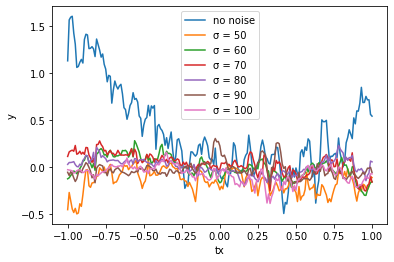

In [87]:
plt.plot(np.linspace(-1, 1, num=201), all_y, label='no noise')
#plt.plot(np.linspace(-1, 1, num=201), np.array(all_y_noisy)[..., :4], label=['σ = 10', 'σ = 20', 'σ = 30', 'σ = 40'])#, 'σ = 50'])#, 'σ = 60', 'σ = 70', 'σ = 80', 'σ = 90', 'σ = 100'])
plt.plot(np.linspace(-1, 1, num=201), np.array(all_y_noisy)[..., 4:], label=['σ = 50', 'σ = 60', 'σ = 70', 'σ = 80', 'σ = 90', 'σ = 100'])
plt.legend()
plt.xlabel('tx')
plt.ylabel('y')
plt.savefig(path+'noisy_ty_only50-100.jpg', dpi=200)

In [14]:
batch_clear_img = []
for i in range(100):
    batch_clear_img.append(clear_img_t[0])

batch_clear_img = torch.stack(batch_clear_img)

In [19]:
ty = 0.

y_random_noisy = []

for tx in range(-100, 101):
    transformation_matrix = [[[0.4, 0, tx/100.], [0, 0.4, ty/100.]]]
    transformation_matrix = torch.tensor(transformation_matrix).float()
    mod_img = place_patch(batch_clear_img, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)
    mod_img += torch.distributions.normal.Normal(loc=0.0, scale=10.).sample(batch_clear_img.shape)
    mod_img.clamp_(0., 255.)


    prediction_mod = torch.stack(model(mod_img.float())).permute(1, 0, 2).squeeze(2).squeeze(0)
    y_random_noisy.append(prediction_mod[..., 1].detach().clone().numpy())

In [20]:
np.min(np.mean(np.array(y_random_noisy), axis=1))

-0.6154074

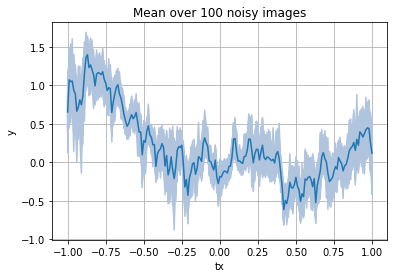

In [22]:
plt.plot(np.linspace(-1, 1, num=len(y_random_noisy)), np.array(y_random_noisy), color='lightsteelblue')
plt.plot(np.linspace(-1, 1, num=len(y_random_noisy)), np.mean(np.array(y_random_noisy), axis=1))
# plt.scatter(0., 1.5, color='red')
plt.title('Mean over 100 noisy images')
plt.xlabel('tx')
plt.ylabel('y')
plt.grid('True')
# plt.scatter(0.42, -0.6370906, color='red')
plt.savefig(path+'noisy_batch_tx.jpg', dpi=200)

In [94]:
tx = 0.

z_random_noisy = []

for ty in range(-100, 101):
    transformation_matrix = [[[0.4, 0, tx/100.], [0, 0.4, ty/100.]]]
    transformation_matrix = torch.tensor(transformation_matrix).float()
    mod_img = place_patch(batch_clear_img, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)
    mod_img += torch.distributions.normal.Normal(loc=0.0, scale=10.).sample(batch_clear_img.shape)
    mod_img.clamp_(0., 255.)


    prediction_mod = torch.stack(model(mod_img.float())).permute(1, 0, 2).squeeze(2).squeeze(0)
    z_random_noisy.append(prediction_mod[..., 2].detach().clone().numpy())

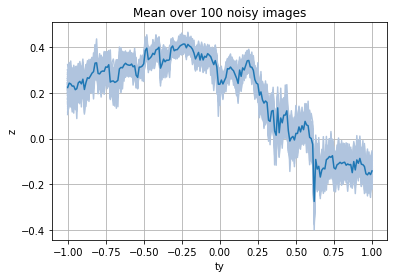

In [96]:
plt.plot(np.linspace(-1, 1, num=len(y_random_noisy)), np.array(z_random_noisy), color='lightsteelblue')
plt.plot(np.linspace(-1, 1, num=len(y_random_noisy)), np.mean(np.array(z_random_noisy), axis=1))
# plt.scatter(0., 1.5, color='red')
plt.title('Mean over 100 noisy images')
plt.xlabel('ty')
plt.ylabel('z')
plt.grid('True')
plt.savefig(path+'noisy_batch_ty.jpg', dpi=200)

In [24]:
target = torch.tensor(-1.0)

tx = torch.tensor([-0.6]).requires_grad_(True)
ty = torch.tensor([0.0])

print(tx, ty)

opt = torch.optim.Adam([tx], lr=1e-1)

optimized_tx_1e1 = []
# optimized_tx.append(tx.detach().clone().item())


rotation_matrix = torch.zeros(1, 2, 2)#.to(transformation_matrix.device)
rotation_matrix[0][0][0] = 0.4
rotation_matrix[0][1][1] = 0.4



for i in range(200):
    #transformation_matrix = [[[0.4, 0, tx/100.], [0, 0.4, ty/100.]]]
    #transformation_matrix = torch.tensor(transformation_matrix).float()
    #rint(transformation_matrix)
    tx_tanh = torch.tanh(tx)

    translation_vector = torch.stack([tx_tanh, ty]).unsqueeze(0)
    #tanh_trans = torch.tanh(translation_vector)
    transformation_matrix = torch.cat((rotation_matrix, translation_vector), dim=2)

    mod_img = place_patch(batch_clear_img, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)
    mod_img += torch.distributions.normal.Normal(loc=0.0, scale=10.).sample(batch_clear_img.shape)
    mod_img.clamp_(0., 255.)

    prediction_mod = torch.stack(model(mod_img.float())).permute(1, 0, 2).squeeze(2).squeeze(0)

    optimized_tx_1e1.append([tx_tanh.detach().clone().item(), torch.mean(prediction_mod[..., 1]).detach().clone().item()])#, prediction_mod[..., 1].detach().clone().numpy()])


    loss = torch.dist(target, prediction_mod[..., 1], p=2)

    opt.zero_grad()
    loss.backward()
    opt.step()

    #tx.data.clamp_(-1., 1.)
    
optimized_tx_1e1.append([tx_tanh.detach().clone().item(), torch.mean(prediction_mod[..., 1]).detach().clone().item()]) #prediction_mod[..., 1].detach().clone().numpy()])

    

tensor([-0.6000], requires_grad=True) tensor([0.])


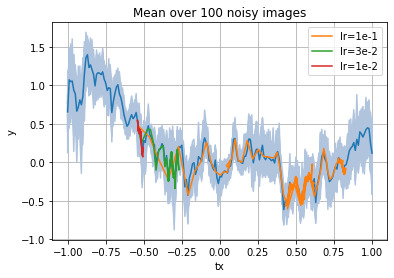

In [26]:
plt.plot(np.linspace(-1, 1, num=len(y_random_noisy)), np.array(y_random_noisy), color='lightsteelblue')
plt.plot(np.linspace(-1, 1, num=201), np.mean(np.array(y_random_noisy), axis=1))
plt.plot(np.array(optimized_tx_1e1).T[0], np.array(optimized_tx_1e1).T[1], label='lr=1e-1')
plt.plot(np.array(optimized_tx_3e2).T[0], np.array(optimized_tx_3e2).T[1], label='lr=3e-2')
plt.plot(np.array(optimized_tx_1e2).T[0], np.array(optimized_tx_1e2).T[1], label='lr=1e-2')
plt.title('Mean over 100 noisy images')
plt.xlabel('tx')
plt.ylabel('y')
plt.grid('True')
plt.legend()
plt.savefig(path+'noisy_batch_tx_optimized.jpg', dpi=200)

In [32]:
optimized_tx_1e1[140]

[0.4443109333515167, -0.6057122945785522]

In [27]:
optimized_tx_1e1[-1]

[0.8000960350036621, -0.04242394492030144]

In [167]:
target = torch.tensor(-0.5)

tx = torch.tensor([0.0])#.requires_grad_(True)
ty = torch.tensor([-0.25]).requires_grad_(True)

print(tx, ty)

opt = torch.optim.Adam([ty], lr=3e-2)

optimized_ty_3e2 = []
# optimized_tx.append(tx.detach().clone().item())


rotation_matrix = torch.zeros(1, 2, 2)#.to(transformation_matrix.device)
rotation_matrix[0][0][0] = 0.4
rotation_matrix[0][1][1] = 0.4



for i in range(200):
    #transformation_matrix = [[[0.4, 0, tx/100.], [0, 0.4, ty/100.]]]
    #transformation_matrix = torch.tensor(transformation_matrix).float()
    #rint(transformation_matrix)
    ty_tanh = torch.tanh(ty)

    translation_vector = torch.stack([tx, ty_tanh]).unsqueeze(0)
    #tanh_trans = torch.tanh(translation_vector)
    transformation_matrix = torch.cat((rotation_matrix, translation_vector), dim=2)

    mod_img = place_patch(batch_clear_img, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)
    mod_img += torch.distributions.normal.Normal(loc=0.0, scale=10.).sample(batch_clear_img.shape)
    mod_img.clamp_(0., 255.)

    prediction_mod = torch.stack(model(mod_img.float())).permute(1, 0, 2).squeeze(2).squeeze(0)

    optimized_ty_3e2.append([ty_tanh.detach().clone().item(), torch.mean(prediction_mod[..., 2]).detach().clone().item()])#, prediction_mod[..., 1].detach().clone().numpy()])


    loss = torch.dist(target, prediction_mod[..., 2], p=2)

    opt.zero_grad()
    loss.backward()
    opt.step()

    #tx.data.clamp_(-1., 1.)
    
optimized_ty_3e2.append([ty_tanh.detach().clone().item(), torch.mean(prediction_mod[..., 2]).detach().clone().item()]) #prediction_mod[..., 1].detach().clone().numpy()])

    

tensor([0.]) tensor([-0.2500], requires_grad=True)


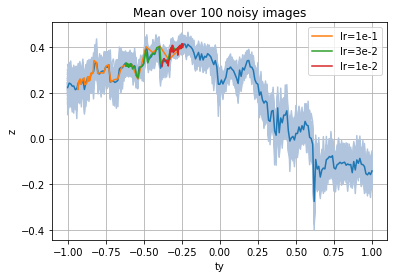

In [169]:
plt.plot(np.linspace(-1, 1, num=len(y_random_noisy)), np.array(z_random_noisy), color='lightsteelblue')
plt.plot(np.linspace(-1, 1, num=len(y_random_noisy)), np.mean(np.array(z_random_noisy), axis=1))
plt.plot(np.array(optimized_ty_1e1).T[0], np.array(optimized_ty_1e1).T[1], label='lr=1e-1')
plt.plot(np.array(optimized_ty_3e2).T[0], np.array(optimized_ty_3e2).T[1], label='lr=3e-2')
plt.plot(np.array(optimized_ty_1e2).T[0], np.array(optimized_ty_1e2).T[1], label='lr=1e-2')
plt.title('Mean over 100 noisy images')
plt.xlabel('ty')
plt.ylabel('z')
plt.grid('True')
plt.legend()
plt.savefig(path+'noisy_batch_ty_optimized.jpg', dpi=200)

In [95]:
all_outputs = []
count = 0

# untargeted_losses = np.zeros((120,170))

# x_min_losses = np.zeros((120, 170))
# x_max_losses = np.zeros((120, 170))

# y_min_losses = np.zeros((120, 170))
# y_max_losses = np.zeros((120, 170))

# z_min_losses = np.zeros((120, 170))
# z_max_losses = np.zeros((120, 170))

x_min_losses = []
x_max_losses = []

y_min_losses = []
y_max_losses = []

z_min_losses = []
z_max_losses = []

prediciton_ori = torch.stack(model(clear_img_t)).permute(1, 0, 2).squeeze(2).squeeze(0)
target_x_min = prediciton_ori.detach().clone()
target_x_min[0] = 0.0

target_x_max = prediciton_ori.detach().clone()
target_x_max[0] = 4.0

target_y_min = prediciton_ori.detach().clone()
target_y_min[1] = -2.0

target_y_max = prediciton_ori.detach().clone()
target_y_max[1] = 2.0


target_z_min = prediciton_ori.detach().clone()
target_z_min[2] = -0.5

target_z_max = prediciton_ori.detach().clone()
target_z_max[2] = 0.5

# target = prediciton_ori.detach().clone()
# target[0] = 1.0

# ty = -0.11

# for i in range(10):
#     noise = torch.distributions.normal.Normal(loc=0.0, scale=10.).sample(img.shape)   #loc == mu, scale == sigma
for tx in range(-80, 80):
    for ty in range(-60, 60):
        transformation_matrix = [[[0.4, 0, tx/100], [0, 0.4, ty/100]]]
        transformation_matrix = torch.tensor(transformation_matrix).float()
        mod_img = place_patch(clear_img_t, custom_patch.unsqueeze(0).unsqueeze(0), transformation_matrix)
        # mod_img += noise


        prediction_mod = torch.stack(model(mod_img.float())).permute(1, 0, 2).squeeze(2).squeeze(0)

        # loss = torch.dist(prediciton_ori, prediction_mod, p=2)
        # loss = torch.dist(target, prediction_mod, p=2)
        # untargeted_losses[ty+60][tx+80] = loss.detach().numpy()


        x_max_losses.append([tx/100, ty/100, torch.dist(target_x_max[0], prediction_mod[0], p=2).detach().cpu().numpy()])
        x_min_losses.append([tx/100, ty/100, torch.dist(target_x_min[0], prediction_mod[0], p=2).detach().cpu().numpy()])

        y_max_losses.append([tx/100, ty/100, torch.dist(target_y_max[1], prediction_mod[1], p=2).detach().cpu().numpy()])
        y_min_losses.append([tx/100, ty/100, torch.dist(target_y_min[1], prediction_mod[1], p=2).detach().cpu().numpy()])

        z_max_losses.append([tx/100, ty/100, torch.dist(target_z_max[2], prediction_mod[2], p=2).detach().cpu().numpy()])
        z_min_losses.append([tx/100, ty/100, torch.dist(target_z_min[2], prediction_mod[2], p=2).detach().cpu().numpy()])
        
        # x_max_losses[ty+60][tx+80] = -torch.dist(target_x_max, prediction_mod, p=2)
        # x_min_losses[ty+60][tx+80] = -torch.dist(target_x_min, prediction_mod, p=2)

        # y_max_losses[ty+60][tx+80] = -torch.dist(target_y_max, prediction_mod, p=2)
        # y_min_losses[ty+60][tx+80] = -torch.dist(target_y_min, prediction_mod, p=2)

        # z_max_losses[ty+60][tx+80] = -torch.dist(target_z_max, prediction_mod, p=2)
        # z_min_losses[ty+60][tx+80] = -torch.dist(target_z_min, prediction_mod, p=2)

        #all_losses.append([tx/100, ty/100, loss.detach().numpy()])
        
        output = prediction_mod.detach().squeeze(0).numpy() # np.array([x[0,0].detach().numpy(), y[0,0].detach().numpy(), z[0,0].detach().numpy(), phi[0,0].detach().numpy()])
        all_outputs.append(output)

        # u, v, w = camera_intrinsics @ camera_extrinsics @ np.concatenate((output[:3], np.array([1])))
        # img_x = u/w
        # img_y = v/w

        count += 1

        # plt.imshow(mod_img.detach().numpy()[0][0], cmap='gray')
        # plt.scatter(img_x, img_y)
        # plt.savefig(path+f"img_{tx/100}_{ty/100}.jpg", dpi=200)
        # plt.close()

# np.save(path+'y_min_l2dist', np.array(all_losses))
np.save(path+'all_predictions', np.array(all_outputs))

np.save(path+'x_max_l2dist', x_max_losses)
np.save(path+'x_min_l2dist', x_min_losses)

np.save(path+'y_max_l2dist', y_max_losses)
np.save(path+'y_min_l2dist', y_min_losses)

np.save(path+'z_max_l2dist', z_max_losses)
np.save(path+'z_min_l2dist', z_min_losses)

/home/pia/Documents/Coding/.front-env/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [96]:
mean_heatmaps = np.array([x_max_losses, x_min_losses, y_max_losses, y_min_losses, z_max_losses, z_min_losses])

(40401, 3)

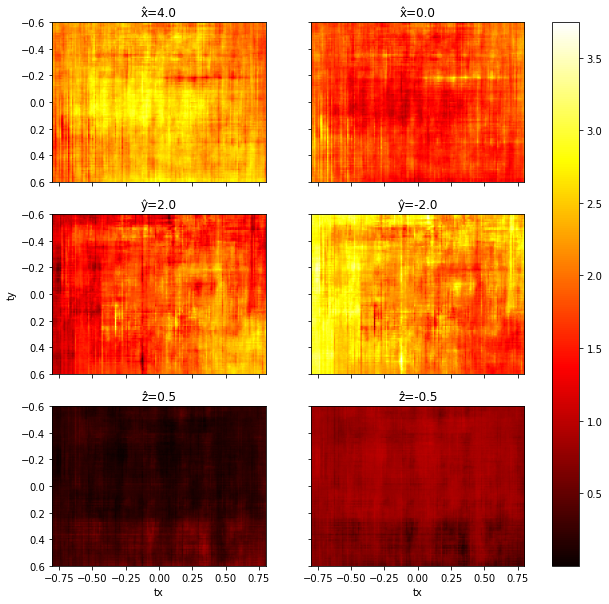

In [98]:
from matplotlib import colors

fig, axs = plt.subplots(3, 2, figsize=(10,10))
# fig.title('Avg. l2 distances')

images = []
z = 0
for i in range(3):
    for j in range(2):
        # Generate data with a range that varies from one plot to the next.
        data = mean_heatmaps[z][...,2]
        z += 1
        images.append(axs[i, j].imshow(data.reshape(160, 120).T, cmap='hot', extent=[-0.8,0.8,0.6,-0.6]))
        axs[i, j].label_outer()

# Find the min and max of all colors for use in setting the color scale.
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)

fig.colorbar(images[0], ax=axs, orientation='vertical', fraction=.1)


# Make images respond to changes in the norm of other images (e.g. via the
# "edit axis, curves and images parameters" GUI on Qt), but be careful not to
# recurse infinitely!
def update(changed_image):
    for im in images:
        if (changed_image.get_cmap() != im.get_cmap()
                or changed_image.get_clim() != im.get_clim()):
            im.set_cmap(changed_image.get_cmap())
            im.set_clim(changed_image.get_clim())


for im in images:
    im.callbacks.connect('changed', update)

# axs[0][0].set_xlabel('tx')
# axs[0][1].set_xlabel('tx')
# axs[1][0].set_xlabel('tx')
# axs[1][1].set_xlabel('tx')
axs[2][0].set_xlabel('tx')
axs[2][1].set_xlabel('tx')
# axs[0][0].set_ylabel('ty')
# axs[0][1].set_ylabel('ty')
axs[1][0].set_ylabel('ty')
# axs[1][1].set_ylabel('ty')
# axs[2][0].set_ylabel('ty')
# axs[2][1].set_ylabel('ty')

axs[0][0].set_title('x̂=4.0')
axs[0][1].set_title('x̂=0.0')

axs[1][0].set_title('ŷ=2.0')
axs[1][1].set_title('ŷ=-2.0')

axs[2][0].set_title('ẑ=0.5')
axs[2][1].set_title('ẑ=-0.5')

plt.savefig("eval_custom_patch/eval_translation/clear_img/heatmaps.jpg", dpi=200)
plt.show()